In [1]:
import os
import argparse
import nibabel as nib
import dipy as dp
from nibabel.streamlines import Field
from nibabel.orientations import aff2axcodes
from dipy.viz import fvtk
from dipy.segment.bundles import RecoBundles

from dipy.segment.metric import ResampleFeature
from dipy.segment.metric import AveragePointwiseEuclideanMetric
from dipy.segment.metric import CenterOfMassFeature
from dipy.segment.metric import EuclideanMetric
from dipy.segment.metric import IdentityFeature
from dipy.segment.clustering import QuickBundles
from dipy.viz import actor, window
from dipy.io.image import load_nifti, save_nifti
import numpy as np

from time import sleep
from dipy.align.streamlinear import StreamlineLinearRegistration
from dipy.tracking.streamline import transform_streamlines
from dipy.tracking.streamline import set_number_of_points
from scipy.interpolate import griddata,RegularGridInterpolator
import matplotlib.pyplot as plt
from dipy.tracking import utils

from scipy import stats
from dipy.io.streamline import load_trk, save_trk
from dipy.tracking.streamline import Streamlines
import statsmodels.stats.multitest as mt

from nibabel.streamlines import Tractogram,save
from dipy.denoise.enhancement_kernel import EnhancementKernel
from dipy.tracking.fbcmeasures import FBCMeasures

In [2]:
NAS="dumbo"
protocole="strokconnect"
DIR_PATH="/NAS/"+NAS+"/protocoles/"+protocole
FS_PATH=DIR_PATH+"/FS53/"
SUBJECT="AUMONT^SEBASTIEN_I_CERE_2014-08-12" #"DE_RIEMAECKER^HENRI_I_CERE_2015-09-08"
TCK_LOCATION=FS_PATH+SUBJECT+'''/dti/'''
all_list=['AUMONT^SEBASTIEN_I_CERE_2014-08-12','BAILLIE^MARIE_PIERRE_STROKE_CONNECT_2014-09-10','BERTELOOT^DAMIEN_I_CERE_2015-03-17','BERTELOOT^PATRICE_I_CERE_2015-09-08','BLANC^HELENE_I_CERE_2014-12-18','BOUMLIK^SAID_I_CERE_2014-09-03','BOURDON^PAULETTE_I_CERE_2015-01-21','CARPENTIER^SANDRA_I_CERE_2014-11-28','CHOPIN^JEAN_MARIE_STROKE_CONNECT_2016-02-29','DAVELUY^WALTER_stroke_connect_2015-04-27','DE_RIEMAECKER^HENRI_I_CERE_2015-09-08','DIAS^ANTHONY_I_CERE_2015-10-20','DJEMAI^ALI_I_CERE_2015-11-16','EZELIN^ERIC_IRM_CEREBRALE_2014-12-10','FACON^PASCALE_I_CERE_2014-12-19','GOSSEIN^JEAN_PIERRE_I_CERE_2014-08-13','HEMARD^VERONIQUE_I_CERE_2016-02-24','HERBIN^GERARD_I_CERE_2015-07-02','KOLLIKER^ALAIN_IRM_CEREBRALE_2016-02-24','KOPCIUCH^FRANCOIS_I_CERE_2015-06-10','Le_Nestour_Christian_2015-07-07','NORO^JEAN_NOEL_STROKE_CONNECT_2015-06-05','NOYON^THADEE_I_CERE_2015-07-03','VANRENTERGHEM^DAVID_I_CERE_2015-10-06','VANTORRE^MICHELE_I_CERE_2015-09-25','VANTORRE^PIERRE_I_CERE_2015-09-25']
pts_list=['AUMONT^SEBASTIEN_I_CERE_2014-08-12','BAILLIE^MARIE_PIERRE_STROKE_CONNECT_2014-09-10','BOUMLIK^SAID_I_CERE_2014-09-03','CHOPIN^JEAN_MARIE_STROKE_CONNECT_2016-02-29','DE_RIEMAECKER^HENRI_I_CERE_2015-09-08','DIAS^ANTHONY_I_CERE_2015-10-20','FACON^PASCALE_I_CERE_2014-12-19','GOSSEIN^JEAN_PIERRE_I_CERE_2014-08-13','HERBIN^GERARD_I_CERE_2015-07-02','NORO^JEAN_NOEL_STROKE_CONNECT_2015-06-05','NOYON^THADEE_I_CERE_2015-07-03','VANRENTERGHEM^DAVID_I_CERE_2015-10-06']#,'HEMARD^VERONIQUE_I_CERE_2016-02-24',
ctrls_list=['BERTELOOT^DAMIEN_I_CERE_2015-03-17','BERTELOOT^PATRICE_I_CERE_2015-09-08','BLANC^HELENE_I_CERE_2014-12-18','BOURDON^PAULETTE_I_CERE_2015-01-21','CARPENTIER^SANDRA_I_CERE_2014-11-28','DAVELUY^WALTER_stroke_connect_2015-04-27','DIAS^ANTHONY_I_CERE_2015-10-20','DJEMAI^ALI_I_CERE_2015-11-16','EZELIN^ERIC_IRM_CEREBRALE_2014-12-10','KOLLIKER^ALAIN_IRM_CEREBRALE_2016-02-24','KOPCIUCH^FRANCOIS_I_CERE_2015-06-10','Le_Nestour_Christian_2015-07-07','VANTORRE^MICHELE_I_CERE_2015-09-25','VANTORRE^PIERRE_I_CERE_2015-09-25']
Cloches=[0,0,2,9,0,2,7,8,3,4,6,0]
ECB=[0,0,0,9,0,0,11,7,2,5,4,0]
Fluff=[15,15,14,13,15,15,10,14,14,12,15,15]
FuflMeyer=[33,59,59,7,33,23,24,11,38,60,6,62]

ctrls_list=['BERTELOOT^DAMIEN_I_CERE_2015-03-17','BERTELOOT^PATRICE_I_CERE_2015-09-08','BLANC^HELENE_I_CERE_2014-12-18','BOURDON^PAULETTE_I_CERE_2015-01-21','CARPENTIER^SANDRA_I_CERE_2014-11-28','DAVELUY^WALTER_stroke_connect_2015-04-27','DJEMAI^ALI_I_CERE_2015-11-16','EZELIN^ERIC_IRM_CEREBRALE_2014-12-10','KOLLIKER^ALAIN_IRM_CEREBRALE_2016-02-24','KOPCIUCH^FRANCOIS_I_CERE_2015-06-10','Le_Nestour_Christian_2015-07-07','VANTORRE^MICHELE_I_CERE_2015-09-25','VANTORRE^PIERRE_I_CERE_2015-09-25']
print(len(ctrls_list))
print(len(pts_list))
print(len(all_list))

for i,j,k,l,m in zip(pts_list,Cloches,ECB,Fluff,FuflMeyer):
    print i,j,k,l,m

13
12
26
AUMONT^SEBASTIEN_I_CERE_2014-08-12 0 0 15 33
BAILLIE^MARIE_PIERRE_STROKE_CONNECT_2014-09-10 0 0 15 59
BOUMLIK^SAID_I_CERE_2014-09-03 2 0 14 59
CHOPIN^JEAN_MARIE_STROKE_CONNECT_2016-02-29 9 9 13 7
DE_RIEMAECKER^HENRI_I_CERE_2015-09-08 0 0 15 33
DIAS^ANTHONY_I_CERE_2015-10-20 2 0 15 23
FACON^PASCALE_I_CERE_2014-12-19 7 11 10 24
GOSSEIN^JEAN_PIERRE_I_CERE_2014-08-13 8 7 14 11
HERBIN^GERARD_I_CERE_2015-07-02 3 2 14 38
NORO^JEAN_NOEL_STROKE_CONNECT_2015-06-05 4 5 12 60
NOYON^THADEE_I_CERE_2015-07-03 6 4 15 6
VANRENTERGHEM^DAVID_I_CERE_2015-10-06 0 0 15 62


In [3]:
import ggplot as gg

/home/global/anaconda2/lib/python2.7/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/home/global/anaconda2/lib/python2.7/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/home/global/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [4]:

#stream_actor = actor.line(cc_sft_native[:],window.colors.blue,linewidth=1)
#stream_actor = actor.line(optimized_sl[:],FA,linewidth=1)
stream_actor = actor.line(streamlines,window.colors.white,linewidth=0.1,opacity=0.3)
#renderer.add(stream_actor)

hue = (0.0,0.0)  # red density_post.jpg
saturation = (0.0, 1.0)  
lut_cmap = actor.colormap_lookup_table(hue_range=hue,saturation_range=saturation)
#bar2 = actor.scalar_bar(lut_cmap)
#renderer.add(bar2)

logp=-1*np.log10(density_post)
logp_th=np.where(logp<1000,logp,0)

lut_cmap = actor.colormap_lookup_table(hue_range=hue,saturation_range=saturation)
stream_actor = actor.line(cc_sft_native[0:100],FA,linewidth=0.1,lookup_colormap=lut_cmap)
#renderer.add(stream_actor)

ima_t1 = nib.load(TCK_LOCATION+"rt1_dti_ras.nii.gz")
ima_t1_data = ima_t1.get_data()
vol_actor = actor.slicer(ima_t1_data)
vol_actor.opacity(1)
vol_actor.display(x=60)
renderer.add(vol_actor)

vol_actor = actor.slicer(ima_t1_data)
vol_actor.display(y=80)
vol_actor.opacity(1)
renderer.add(vol_actor)

vol_actor = actor.slicer(ima_t1_data)
vol_actor.display(z=25)
vol_actor.opacity(1)
renderer.add(vol_actor)

##affichage du target 

imgTarget=nib.load(TCK_LOCATION+"target.nii.gz")
mask = imgTarget.get_data()
if not world_coords:
    vol_actor = actor.slicer(mask,affine=np.eye(4),opacity=0.5)
else:
    vol_actor = actor.slicer(mask,imgTarget.affine,opacity=0.5)
vol_actor.display(z=30)
#renderer.add(vol_actor)

target = mask == 1
seedroi_actor = actor.contour_from_roi(target,np.eye(4),[1, 0, 0], 1)
renderer.add(seedroi_actor)

if not world_coords:
    vol_actor = actor.slicer(reference_anatomy_data,affine=np.eye(4),opacity=0.5)
else:
    vol_actor = actor.slicer(reference_anatomy_data,reference_anatomy.affine,opacity=0.5)
vol_actor.display(x=60)
renderer.add(vol_actor)

renderer.set_camera(position=(221.72, -1.10, 53.08),
                    focal_point=(63.50, 63.50, 32.50),
                    view_up=(-0.16, -0.07, 0.99))

#window.record(renderer, out_path='/NAS/dumbo/protocoles/Thalamotomy/3DView_fa_pre_post.png', size=(1200,1200))
window.show(renderer, size=(600, 600), reset_camera=False)
#renderer.camera_info()

NameError: name 'streamlines' is not defined

# Stats dans espace native et Visu dans espace MNI 

In [94]:
D33 = 1.0
D44 = 0.02
t = 1
k = EnhancementKernel(D33, D44, t)

feature = ResampleFeature(nb_points=20)
metric = AveragePointwiseEuclideanMetric(feature=feature)  # a.k.a. MDF  
qb = QuickBundles(threshold=10,metric=metric)
qb.max_nb_clusters = 1
    
srr = StreamlineLinearRegistration()
nbValues=20
saturation = [0.0,1.0]  # white to red
lut_cmap = actor.colormap_lookup_table(scale_range=(3,3.5),hue_range=[0.0,0.0],saturation_range=saturation)

#dataMNI, affineMNI = load_nifti("/home/global/fsl5011/data/standard/MNI152_T1_1mm_brain.nii.gz")  
dataMNI, affineMNI = load_nifti(FS_PATH+'''AUMONT^SEBASTIEN_I_CERE_2014-08-12/dti/'''+"dti_finalcor_FA.nii")

ren_ECB = window.ren()
ren_Fluff = window.ren()
ren_Cloches = window.ren()
ren_FluffMeyer = window.ren()

#['dti_finalcor_FA.nii','dti_finalcor_MO.nii.gz','dti_finalcor_S0.nii.gz','dti_finalcor_MD.nii.gz','dti_finalcor_L3.nii.gz','dti_finalcor_L2.nii.gz','dti_finalcor_L1.nii.gz']:
for FILE in ['dti_finalcor_S0.nii.gz','dti_finalcor_L1.nii.gz']:
    window.rm_all(ren_ECB)
    window.rm_all(ren_Fluff)
    window.rm_all(ren_Cloches)
    window.rm_all(ren_FluffMeyer)
    
    print(FILE)
    for STR_FX in ['slf_i.right','slf_ii.right','slf_iii.right','slf_i.left','slf_ii.left','slf_iii.left','cc_parietal']:    
        wholeTracks = []
        #streams, hdr = load_trk('/home/romain/Téléchargements/tracks/association/SLF_L.trk.gz')
        #fix_tracks = Streamlines(streams)
        dpw_fix = dp.io.dpy.Dpy(FS_PATH+'''AUMONT^SEBASTIEN_I_CERE_2014-08-12/dti/'''+STR_FX+".dpy", 'r')
        fix_tracks=dpw_fix.read_tracks();
        fix_tracks_native = transform_streamlines(fix_tracks, np.linalg.inv(affineMNI))
        fix_tracks_native = set_number_of_points(fix_tracks_native, 20)
        #ren.add(actor.line(fix_tracks_native,window.colors.blue,linewidth=1,opacity=1))
        resu_FA=np.empty([0,nbValues])
        list_FA=[]
        Cloches_sub=[]
        ECB_sub=[]
        Fluff_sub=[]
        FluffMeyer_sub=[]
        for SUBJECT in pts_list:    
            TCK_LOCATION=FS_=FS_PATH+SUBJECT+'''/dti/'''
            if os.path.exists(TCK_LOCATION+STR_FX+".dpy"):
                dpw = dp.io.dpy.Dpy(TCK_LOCATION+STR_FX+".dpy", 'r')
                tracks=dpw.read_tracks();
                print(TCK_LOCATION+" "+STR_FX +" "+str(len(tracks)))                
                if (len(tracks)>0) & os.path.exists(TCK_LOCATION+FILE):
                    data, affine = load_nifti(TCK_LOCATION+FILE)  
                    tracks_native = transform_streamlines(tracks, np.linalg.inv(affine))       
                    cluster_native = qb.cluster(tracks_native)  
                    tracks_native = set_number_of_points(tracks_native, 20)                    
                    srm = srr.optimize(static=fix_tracks_native, moving=tracks_native)
                    tracks_aligned = srm.transform(tracks_native)                    
                    for s in tracks_aligned:
                        wholeTracks.append(s) 
                    x = np.linspace(1, data.shape[0], data.shape[0])
                    y = np.linspace(1, data.shape[1], data.shape[1])
                    z = np.linspace(1, data.shape[2], data.shape[2])
                    my_interpolating_function = RegularGridInterpolator((x, y, z), data)
                    tmp=my_interpolating_function(cluster_native.centroids)
                    resu_FA=np.concatenate((resu_FA, tmp), axis=0)
                    list_FA.append(SUBJECT+'_'+STR_FX)
                else: 
                    break
            else:
                print(SUBJECT+" "+STR_FX +" No tracks")
        for cpt1 in range(len(pts_list)):
            for cpt2 in range(len(list_FA)):
                if pts_list[cpt1] in list_FA[cpt2]:
                    #ECB,Fluff,FuflMeyer,Cloches
                    Cloches_sub.append(Cloches[cpt1])      
                    ECB_sub.append(ECB[cpt1])
                    Fluff_sub.append(Fluff[cpt1])
                    FluffMeyer_sub.append(FuflMeyer[cpt1])                                
        pval_FA_Cloches=[]
        pval_FA_ECB=[]
        pval_FA_Fluff=[]
        pval_FA_FluffMeyer=[]
        print(resu_FA)
        print(Cloches_sub)
        print(ECB_sub)
        print(Fluff_sub)
        print(FluffMeyer_sub)
        for cpt in range(resu_FA.shape[1]):
            rho,pval=stats.spearmanr(Cloches_sub,resu_FA[:,cpt],axis=0) 
            pval_FA_Cloches.append(pval)
            rho,pval=stats.spearmanr(ECB_sub,resu_FA[:,cpt],axis=0) 
            pval_FA_ECB.append(pval)
            rho,pval=stats.spearmanr(Fluff_sub,resu_FA[:,cpt],axis=0) 
            pval_FA_Fluff.append(pval)
            rho,pval=stats.spearmanr(FluffMeyer_sub,resu_FA[:,cpt],axis=0) 
            pval_FA_FluffMeyer.append(pval)
        
        # Apply FBC measures
        #http://nipy.org/dipy/examples_built/fiber_to_bundle_coherence.html
        fbc = FBCMeasures(wholeTracks, k)        
        
        save(Tractogram(wholeTracks, affine_to_rasmm=np.eye(4)),FS_PATH+"Dirty_whole_"+STR_FX+".trk")
        # Apply a threshold on the RFBC to remove spurious fibers
        wholeTracks_thres, clrs_thres, rfbc_thres = fbc.get_points_rfbc_thresholded(0.2, emphasis=0.01)
    
        save(Tractogram(wholeTracks_thres, affine_to_rasmm=np.eye(4)),FS_PATH+"whole_"+STR_FX+".trk")
        
        #dpw = dp.io.dpy.Dpy(FS_PATH+"whole_"+STR_FX+".dpy", 'w')
        #for s in wholeTracks:
        #    dpw.write_tracks(s)
        #dpw.close()
        
        ren_ECB.add(actor.line(wholeTracks_thres,window.colors.white,linewidth=0.1,opacity=0.2))  
        ren_Cloches.add(actor.line(wholeTracks_thres,window.colors.white,linewidth=0.1,opacity=0.2))  
        ren_Fluff.add(actor.line(wholeTracks_thres,window.colors.white,linewidth=0.1,opacity=0.2))  
        ren_FluffMeyer.add(actor.line(wholeTracks_thres,window.colors.white,linewidth=0.1,opacity=0.2))  

        
        cluster_aligned = qb.cluster(wholeTracks)  
        [pval_corr_bool,pval_FA_corr,c,d]=mt.multipletests(pval_FA_Cloches, alpha=0.05, method='fdr_bh', is_sorted=False,returnsorted=False)    
        ren_ECB.add(actor.line(cluster_aligned.centroids,-1*np.log(pval_FA_corr),linewidth=5,lookup_colormap=lut_cmap))
        ren_Cloches.add(actor.line(cluster_aligned.centroids,-1*np.log(pval_FA_corr),linewidth=5,lookup_colormap=lut_cmap))
        ren_Fluff.add(actor.line(cluster_aligned.centroids,-1*np.log(pval_FA_corr),linewidth=5,lookup_colormap=lut_cmap))
        ren_FluffMeyer.add(actor.line(cluster_aligned.centroids,-1*np.log(pval_FA_corr),linewidth=5,lookup_colormap=lut_cmap))
        print(pval)
        print(pval_FA_corr)
        print(pval_corr_bool)
        
        [pval_corr_bool,pval_FA_corr,c,d]=mt.multipletests(pval_FA_ECB, alpha=0.05, method='fdr_bh', is_sorted=False,returnsorted=False)    
        ren_ECB.add(actor.line(cluster_aligned.centroids,-1*np.log(pval_FA_corr),linewidth=5,lookup_colormap=lut_cmap))
        ren_Cloches.add(actor.line(cluster_aligned.centroids,-1*np.log(pval_FA_corr),linewidth=5,lookup_colormap=lut_cmap))
        ren_Fluff.add(actor.line(cluster_aligned.centroids,-1*np.log(pval_FA_corr),linewidth=5,lookup_colormap=lut_cmap))
        ren_FluffMeyer.add(actor.line(cluster_aligned.centroids,-1*np.log(pval_FA_corr),linewidth=5,lookup_colormap=lut_cmap))
        print(pval)        
        print(pval_FA_corr)
        print(pval_corr_bool)   
        
        [pval_corr_bool,pval_FA_corr,c,d]=mt.multipletests(pval_FA_Fluff, alpha=0.05, method='fdr_bh', is_sorted=False,returnsorted=False)    
        ren_ECB.add(actor.line(cluster_aligned.centroids,-1*np.log(pval_FA_corr),linewidth=5,lookup_colormap=lut_cmap))
        ren_Cloches.add(actor.line(cluster_aligned.centroids,-1*np.log(pval_FA_corr),linewidth=5,lookup_colormap=lut_cmap))
        ren_Fluff.add(actor.line(cluster_aligned.centroids,-1*np.log(pval_FA_corr),linewidth=5,lookup_colormap=lut_cmap))
        ren_FluffMeyer.add(actor.line(cluster_aligned.centroids,-1*np.log(pval_FA_corr),linewidth=5,lookup_colormap=lut_cmap))
        print(pval)
        print(pval_FA_corr)
        print(pval_corr_bool)
        
        [pval_corr_bool,pval_FA_corr,c,d]=mt.multipletests(pval_FA_FluffMeyer, alpha=0.05, method='fdr_bh', is_sorted=False,returnsorted=False)    
        ren_ECB.add(actor.line(cluster_aligned.centroids,-1*np.log(pval_FA_corr),linewidth=5,lookup_colormap=lut_cmap))
        ren_Cloches.add(actor.line(cluster_aligned.centroids,-1*np.log(pval_FA_corr),linewidth=5,lookup_colormap=lut_cmap))
        ren_Fluff.add(actor.line(cluster_aligned.centroids,-1*np.log(pval_FA_corr),linewidth=5,lookup_colormap=lut_cmap))
        ren_FluffMeyer.add(actor.line(cluster_aligned.centroids,-1*np.log(pval_FA_corr),linewidth=5,lookup_colormap=lut_cmap))
        print(pval)
        print(pval_FA_corr)
        print(pval_corr_bool)
        
    bar2 = actor.scalar_bar(lut_cmap)
    #ren.add(bar2)
    surface_opacity=0.2
    surface_color=[0.75, 0.75, 0.75]
    v = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0],[0, 0, 0, 1]])
    ren.add(actor.contour_from_roi(dataMNI,v,surface_color, surface_opacity))
    image_actor_z = actor.slicer(dataMNI,affine=np.eye(4),opacity=0.5)# affineMNI)
    ren_ECB.add(image_actor_z)
    ren_Cloches.add(image_actor_z)
    ren_Fluff.add(image_actor_z)
    ren_FluffMeyer.add(image_actor_z)    

    window.show(ren_ECB) 
    window.record(ren_ECB, out_path=FILE+'_ECB.png', size=(1200, 900),reset_camera=False)

    window.show(ren_Cloches)
    window.record(ren_Cloches, out_path=FILE+'_Cloches.png', size=(1200, 900),reset_camera=False)

    window.show(ren_Fluff)
    window.record(ren_Fluff, out_path=FILE+'_Fluff.png', size=(1200, 900),reset_camera=False)

    window.show(ren_FluffMeyer)
    window.record(ren_FluffMeyer, out_path=FILE+'_FluffMeyer.png', size=(1200, 900),reset_camera=False)

window.show(ren_ECB) 
window.show(ren_Cloches)
window.show(ren_Fluff)
window.show(ren_FluffMeyer)
    
    #ren.reset_camera()
    #ren.reset_clipping_range()
    #window.record(ren, out_path='lat.png', size=(1200, 900),reset_camera=True)

The kernel already exists. Loading from /tmp/kernel_d33@1.00_d44@0.02_t@1.00_numverts100.npy
dti_finalcor_S0.nii.gz
/NAS/dumbo/protocoles/strokconnect/FS53/AUMONT^SEBASTIEN_I_CERE_2014-08-12/dti/ slf_i.right 91
/NAS/dumbo/protocoles/strokconnect/FS53/BAILLIE^MARIE_PIERRE_STROKE_CONNECT_2014-09-10/dti/ slf_i.right 85
/NAS/dumbo/protocoles/strokconnect/FS53/BOUMLIK^SAID_I_CERE_2014-09-03/dti/ slf_i.right 63
/NAS/dumbo/protocoles/strokconnect/FS53/CHOPIN^JEAN_MARIE_STROKE_CONNECT_2016-02-29/dti/ slf_i.right 18
/NAS/dumbo/protocoles/strokconnect/FS53/DE_RIEMAECKER^HENRI_I_CERE_2015-09-08/dti/ slf_i.right 43
DIAS^ANTHONY_I_CERE_2015-10-20 slf_i.right No tracks
FACON^PASCALE_I_CERE_2014-12-19 slf_i.right No tracks
GOSSEIN^JEAN_PIERRE_I_CERE_2014-08-13 slf_i.right No tracks
/NAS/dumbo/protocoles/strokconnect/FS53/HERBIN^GERARD_I_CERE_2015-07-02/dti/ slf_i.right 25
/NAS/dumbo/protocoles/strokconnect/FS53/NORO^JEAN_NOEL_STROKE_CONNECT_2015-06-05/dti/ slf_i.right 2
/NAS/dumbo/protocoles/strokcon

/NAS/dumbo/protocoles/strokconnect/FS53/AUMONT^SEBASTIEN_I_CERE_2014-08-12/dti/ slf_iii.right 916
/NAS/dumbo/protocoles/strokconnect/FS53/BAILLIE^MARIE_PIERRE_STROKE_CONNECT_2014-09-10/dti/ slf_iii.right 920
/NAS/dumbo/protocoles/strokconnect/FS53/BOUMLIK^SAID_I_CERE_2014-09-03/dti/ slf_iii.right 473
/NAS/dumbo/protocoles/strokconnect/FS53/CHOPIN^JEAN_MARIE_STROKE_CONNECT_2016-02-29/dti/ slf_iii.right 631
/NAS/dumbo/protocoles/strokconnect/FS53/DE_RIEMAECKER^HENRI_I_CERE_2015-09-08/dti/ slf_iii.right 855
DIAS^ANTHONY_I_CERE_2015-10-20 slf_iii.right No tracks
FACON^PASCALE_I_CERE_2014-12-19 slf_iii.right No tracks
GOSSEIN^JEAN_PIERRE_I_CERE_2014-08-13 slf_iii.right No tracks
/NAS/dumbo/protocoles/strokconnect/FS53/HERBIN^GERARD_I_CERE_2015-07-02/dti/ slf_iii.right 346
/NAS/dumbo/protocoles/strokconnect/FS53/NORO^JEAN_NOEL_STROKE_CONNECT_2015-06-05/dti/ slf_iii.right 18
/NAS/dumbo/protocoles/strokconnect/FS53/NOYON^THADEE_I_CERE_2015-07-03/dti/ slf_iii.right 29
VANRENTERGHEM^DAVID_I_CERE

/NAS/dumbo/protocoles/strokconnect/FS53/AUMONT^SEBASTIEN_I_CERE_2014-08-12/dti/ slf_ii.left 3181
/NAS/dumbo/protocoles/strokconnect/FS53/BAILLIE^MARIE_PIERRE_STROKE_CONNECT_2014-09-10/dti/ slf_ii.left 1993
/NAS/dumbo/protocoles/strokconnect/FS53/BOUMLIK^SAID_I_CERE_2014-09-03/dti/ slf_ii.left 1283
/NAS/dumbo/protocoles/strokconnect/FS53/CHOPIN^JEAN_MARIE_STROKE_CONNECT_2016-02-29/dti/ slf_ii.left 3336
/NAS/dumbo/protocoles/strokconnect/FS53/DE_RIEMAECKER^HENRI_I_CERE_2015-09-08/dti/ slf_ii.left 1399
DIAS^ANTHONY_I_CERE_2015-10-20 slf_ii.left No tracks
FACON^PASCALE_I_CERE_2014-12-19 slf_ii.left No tracks
GOSSEIN^JEAN_PIERRE_I_CERE_2014-08-13 slf_ii.left No tracks
/NAS/dumbo/protocoles/strokconnect/FS53/HERBIN^GERARD_I_CERE_2015-07-02/dti/ slf_ii.left 353
/NAS/dumbo/protocoles/strokconnect/FS53/NORO^JEAN_NOEL_STROKE_CONNECT_2015-06-05/dti/ slf_ii.left 144
/NAS/dumbo/protocoles/strokconnect/FS53/NOYON^THADEE_I_CERE_2015-07-03/dti/ slf_ii.left 16
VANRENTERGHEM^DAVID_I_CERE_2015-10-06 slf_

/NAS/dumbo/protocoles/strokconnect/FS53/AUMONT^SEBASTIEN_I_CERE_2014-08-12/dti/ cc_parietal 2730
/NAS/dumbo/protocoles/strokconnect/FS53/BAILLIE^MARIE_PIERRE_STROKE_CONNECT_2014-09-10/dti/ cc_parietal 853
/NAS/dumbo/protocoles/strokconnect/FS53/BOUMLIK^SAID_I_CERE_2014-09-03/dti/ cc_parietal 474
/NAS/dumbo/protocoles/strokconnect/FS53/CHOPIN^JEAN_MARIE_STROKE_CONNECT_2016-02-29/dti/ cc_parietal 2472
/NAS/dumbo/protocoles/strokconnect/FS53/DE_RIEMAECKER^HENRI_I_CERE_2015-09-08/dti/ cc_parietal 1176
/NAS/dumbo/protocoles/strokconnect/FS53/DIAS^ANTHONY_I_CERE_2015-10-20/dti/ cc_parietal 0
[[ 212.13493001  200.58391999  206.68585297  220.38031555  245.73499827
   271.56186362  256.35217109  244.70472085  233.00217863  199.78420809
   199.63773432  197.15961438  204.37155891  228.88453492  239.03090186
   219.44508274  198.90910981  179.59266247  173.55904683  187.21875121]
 [ 170.11037683  156.09931121  171.6262128   189.72620593  202.22460912
   197.58469619  220.93648125  236.10693173  2

/NAS/dumbo/protocoles/strokconnect/FS53/CHOPIN^JEAN_MARIE_STROKE_CONNECT_2016-02-29/dti/ slf_ii.right 362
/NAS/dumbo/protocoles/strokconnect/FS53/DE_RIEMAECKER^HENRI_I_CERE_2015-09-08/dti/ slf_ii.right 792
DIAS^ANTHONY_I_CERE_2015-10-20 slf_ii.right No tracks
FACON^PASCALE_I_CERE_2014-12-19 slf_ii.right No tracks
GOSSEIN^JEAN_PIERRE_I_CERE_2014-08-13 slf_ii.right No tracks
/NAS/dumbo/protocoles/strokconnect/FS53/HERBIN^GERARD_I_CERE_2015-07-02/dti/ slf_ii.right 293
/NAS/dumbo/protocoles/strokconnect/FS53/NORO^JEAN_NOEL_STROKE_CONNECT_2015-06-05/dti/ slf_ii.right 22
/NAS/dumbo/protocoles/strokconnect/FS53/NOYON^THADEE_I_CERE_2015-07-03/dti/ slf_ii.right 12
VANRENTERGHEM^DAVID_I_CERE_2015-10-06 slf_ii.right No tracks
[[ 0.00167435  0.0010218   0.00109299  0.00114537  0.00106773  0.00101074
   0.00109333  0.00128644  0.00136911  0.00121952  0.00135949  0.00119239
   0.00101111  0.00090218  0.0010192   0.00099872  0.00090351  0.00095886
   0.00093377  0.00094976]
 [ 0.00097946  0.00103647 

/NAS/dumbo/protocoles/strokconnect/FS53/BOUMLIK^SAID_I_CERE_2014-09-03/dti/ slf_i.left 60
/NAS/dumbo/protocoles/strokconnect/FS53/CHOPIN^JEAN_MARIE_STROKE_CONNECT_2016-02-29/dti/ slf_i.left 57
/NAS/dumbo/protocoles/strokconnect/FS53/DE_RIEMAECKER^HENRI_I_CERE_2015-09-08/dti/ slf_i.left 13
DIAS^ANTHONY_I_CERE_2015-10-20 slf_i.left No tracks
FACON^PASCALE_I_CERE_2014-12-19 slf_i.left No tracks
GOSSEIN^JEAN_PIERRE_I_CERE_2014-08-13 slf_i.left No tracks
/NAS/dumbo/protocoles/strokconnect/FS53/HERBIN^GERARD_I_CERE_2015-07-02/dti/ slf_i.left 10
/NAS/dumbo/protocoles/strokconnect/FS53/NORO^JEAN_NOEL_STROKE_CONNECT_2015-06-05/dti/ slf_i.left 0
[[ 0.00100427  0.00087952  0.0008602   0.00081882  0.00080648  0.00091505
   0.00118868  0.00117607  0.00115761  0.00120421  0.00090037  0.00082442
   0.00088138  0.00089355  0.00090503  0.0010565   0.00101394  0.00089126
   0.00089272  0.00091964]
 [ 0.00094542  0.00124915  0.00112496  0.00106189  0.00099215  0.00099369
   0.00107108  0.0010059   0.0008

KeyboardInterrupt: 

In [ ]:
print pval_FA_Cloches

le code ci-dessous va rassembler les fichiers tck/trk d'un bundle dans un fichier dpy
(avant j'ai utilisé BundleSeg afin de créer les fichiers tck/trk cf. fichier runBatch.sh) 

In [10]:
for SUBJECT in ctrls_list:
    TCK_LOCATION=FS_PATH+SUBJECT+'''/dti/'''
    for STR_FX in ['cc_parietal','extreme_capsule.left','extreme_capsule.right','internal_capsule_new.left','internal_capsule_new.right','slf_i.left','slf_i.right','ioff.left','ioff.right','soff.left','soff.right','mdlf.left','mdlf.right','ec.left','ec.right','cb.left','cb.right','cst.left','cst.right','thalamo_frontal.left','thalamo_frontal.right','thalamo_occipital.left','thalamo_occipital.right','thalamo_parietal.left','thalamo_parietal.right','uf.left','uf.right','af.left','af.right','cc_1','cc_2','cc_3','cc_4','cc_7','ilf.left','ilf.right','internal_capsule_new.left','slf_iii.left','slf_iii.right','slf_ii.left','slf_ii.right','striato_frontal.left','striato_frontal.right','striato_occipital.left','striato_occipital.right','striato_parietal.left','striato_parietal.right']:
        #print(TCK_LOCATION+STR_FX+".dpy")
        #if os.path.exists(TCK_LOCATION+STR_FX+".dpy"):
        #    os.remove(TCK_LOCATION+STR_FX+".dpy")
        dpw = dp.io.dpy.Dpy(TCK_LOCATION+STR_FX+".dpy", 'w')                
        for root, dirs, files in os.walk(TCK_LOCATION):    
            for file in files:
                if file.startswith('whole_brain_6_1500000_part') & file.endswith(STR_FX+'.tck'):
                    bundle = nib.streamlines.load(root+file)
                    dpw.write_tracks(bundle.streamlines)
                    os.remove(root+file)
        dpw.close()

In [47]:
feature = ResampleFeature(nb_points=200)
metric = AveragePointwiseEuclideanMetric(feature=feature)  # a.k.a. MDF  
qb = QuickBundles(threshold=10,metric=metric)
qb.max_nb_clusters = 1

ctrls=[]
pts=[]
for STR_FX in ['slf_i.right','slf_ii.right','slf_iii.right','slf_i.left','slf_ii.left','slf_iii.left','cc_parietal']:    
    print(STR_FX)
    for SUBJECT in ctrls_list:
        FILE='dti_finalcor_FA.nii'
        TCK_LOCATION=FS_=FS_PATH+SUBJECT+'''/dti/'''
        data, affine = load_nifti(TCK_LOCATION+FILE)  
        dpw = dp.io.dpy.Dpy(TCK_LOCATION+STR_FX+".dpy", 'r')
        tracks=dpw.read_tracks();
        tracks_native = transform_streamlines(tracks, np.linalg.inv(affine))  
        cluster_native = qb.cluster(tracks_native)  
        x = np.linspace(1, data.shape[0], data.shape[0])
        y = np.linspace(1, data.shape[1], data.shape[1])
        z = np.linspace(1, data.shape[2], data.shape[2])
        my_interpolating_function = RegularGridInterpolator((x, y, z), data)
        tmp=my_interpolating_function(cluster_native.centroids)
        ctrls.append(np.mean(tmp))

    for SUBJECT in pts_list:
        FILE='dti_finalcor_FA.nii'
        TCK_LOCATION=FS_=FS_PATH+SUBJECT+'''/dti/'''
        if os.path.exists(TCK_LOCATION+FILE):
            data, affine = load_nifti(TCK_LOCATION+FILE)  
            if os.path.exists(TCK_LOCATION+STR_FX+".dpy"):
                dpw = dp.io.dpy.Dpy(TCK_LOCATION+STR_FX+".dpy", 'r')
                tracks=dpw.read_tracks();
                tracks_native = transform_streamlines(tracks, np.linalg.inv(affine))  
                cluster_native = qb.cluster(tracks_native)  
                x = np.linspace(1, data.shape[0], data.shape[0])
                y = np.linspace(1, data.shape[1], data.shape[1])
                z = np.linspace(1, data.shape[2], data.shape[2])
                my_interpolating_function = RegularGridInterpolator((x, y, z), data)
                tmp=my_interpolating_function(cluster_native.centroids)
                pts.append(np.mean(tmp))

    #print(ctrls)
    #print(pts)
    print(stats.ks_2samp(pts,ctrls))
    print(stats.mannwhitneyu(pts,ctrls))

slf_i.right
Ks_2sampResult(statistic=0.75, pvalue=0.0031544770417342035)
MannwhitneyuResult(statistic=23.0, pvalue=0.019509358367874825)
slf_ii.right
Ks_2sampResult(statistic=0.38461538461538458, pvalue=0.079422041563088477)
MannwhitneyuResult(statistic=130.0, pvalue=0.022359074150579753)
slf_iii.right
Ks_2sampResult(statistic=0.25, pvalue=0.26918734074849776)
MannwhitneyuResult(statistic=413.0, pvalue=0.22024568373730513)
slf_i.left
Ks_2sampResult(statistic=0.16346153846153844, pvalue=0.62516720677181947)
MannwhitneyuResult(statistic=760.0, pvalue=0.255081779068278)
slf_ii.left
Ks_2sampResult(statistic=0.13076923076923075, pvalue=0.76152956407287387)
MannwhitneyuResult(statistic=1215.0, pvalue=0.28856537253828007)
slf_iii.left
Ks_2sampResult(statistic=0.097756410256410242, pvalue=0.92620850723278925)
MannwhitneyuResult(statistic=1796.0, pvalue=0.35223742911592687)
cc_parietal
Ks_2sampResult(statistic=0.10344827586206895, pvalue=0.82221936433926135)
MannwhitneyuResult(statistic=2494.0,

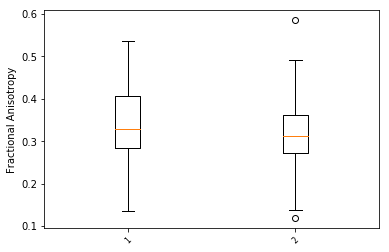

[0.40843945507128171, 0.41729962435753287, 0.4177026240570878, 0.44830513813034478, 0.49158024241820264, 0.49708341652557764, 0.41272331769046949, 0.44215778977277403, 0.43833112975919375, 0.45859678877931143, 0.3890643688674908, 0.47380019607473528, 0.44880353015271751, 0.32473259236144486, 0.32890215502229231, 0.2956712597037412, 0.18084858746126659, 0.30629222131041972, 0.33821003339081257, 0.30954287192035701, 0.26451995964220276, 0.28143333067600912, 0.33883614893233227, 0.34948707494478709, 0.29546192663289622, 0.32069207529367799, 0.19984827795912793, 0.20001669030877817, 0.26205995657640813, 0.17393123313550826, 0.135644836827297, 0.27669030481455731, 0.24173757900698825, 0.26554156776723997, 0.25894103960576464, 0.29118839281933584, 0.22143144962966155, 0.28498066592649385, 0.3463122144305929, 0.23532668299873091, 0.36073702165627269, 0.38064494572142749, 0.25775040659638321, 0.2824927552126752, 0.37091758537638059, 0.31583465670997862, 0.32392698003734144, 0.38809447275823972

In [92]:


#cleanedList1=np.asarray(pts)
#cleanedList[cleanedList!='nan']
    
cleanedList2 = [x for x in cleanedList1 if str(x) != 'nan']
data=[]
#fig = plt.figure(1, figsize=(9, 6))
fig,ax = plt.subplots()
ax.set_ylabel('Fractional Anisotropy')
ax.set_xticklabels(('Controls,Patients'),rotation=45, fontsize=8)
data.append(ctrls)
data.append(cleanedList2)
ax.boxplot(data)
plt.show()
print(ctrls)

print(type(pts))

In [90]:
import numpy as np
import matplotlib.pyplot as plt

data = [[np.random.rand(100)] for i in range(3)]
plt.boxplot(data)
plt.xticks([1, 2, 3], ['mon', 'tue', 'wed'])

([<matplotlib.axis.XTick at 0x7ff9f8dda150>,
 <a list of 3 Text xticklabel objects>)

In [5]:
SUBJECT='AUMONT^SEBASTIEN_I_CERE_2014-08-12'
print(FS_PATH+SUBJECT)
fdwi = FS_PATH+SUBJECT+'''/dti/dti.nii.gz'''
fbval = FS_PATH+SUBJECT+'''/dti/dti.bval'''
fbvec = FS_PATH+SUBJECT+'''/dti/dti.bvec'''

from dipy.io.image import load_nifti, save_nifti
from dipy.io import read_bvals_bvecs
from dipy.core.gradients import gradient_table
from dipy.reconst.dti import TensorModel

data, affine = load_nifti(fdwi)
bvals, bvecs = read_bvals_bvecs(fbval, fbvec)
gtab = gradient_table(bvals, bvecs)

tenmodel = TensorModel(gtab)
tenfit = tenmodel.fit(data)

renderer = window.Renderer()
renderer.background((0.5, 0.5, 0.5))
fa_actor = actor.slicer(tenfit.color_fa, affine)
renderer.add(fa_actor)
window.show(renderer, size=(600,600), reset_camera=True)

window.record(renderer, out_path='slices.png', size=(600,600),reset_camera=True)
#save_nifti(FS_PATH+SUBJECT+'''/dti/colorfa.nii.gz''', tenfit.color_fa, affine)

/NAS/dumbo/protocoles/strokconnect/FS53/AUMONT^SEBASTIEN_I_CERE_2014-08-12


## Visu bundle associatif

In [295]:
ren = window.ren()
SUBJECT='BERTELOOT^DAMIEN_I_CERE_2015-03-17'
TCK_LOCATION=FS_=FS_PATH+SUBJECT+'''/dti/'''  
data, affine = load_nifti(FS_PATH+SUBJECT+"/mri/raparc+aseg.nii.gz")
STR_FX='slf_i.left'
dpw = dp.io.dpy.Dpy(TCK_LOCATION+STR_FX+".dpy", 'r')
tracks=dpw.read_tracks();
tracks_onFA = transform_streamlines(tracks, np.linalg.inv(affine))
ren.add(actor.line(tracks_onFA,window.colors.red,linewidth=0.1))     
STR_FX='slf_ii.left'
dpw = dp.io.dpy.Dpy(TCK_LOCATION+STR_FX+".dpy", 'r')
tracks=dpw.read_tracks();
tracks_onFA = transform_streamlines(tracks, np.linalg.inv(affine))
ren.add(actor.line(tracks_onFA,window.colors.green,linewidth=0.1)) 
STR_FX='slf_iii.left'
dpw = dp.io.dpy.Dpy(TCK_LOCATION+STR_FX+".dpy", 'r')
tracks=dpw.read_tracks();
tracks_onFA = transform_streamlines(tracks, np.linalg.inv(affine))
ren.add(actor.line(tracks_onFA,window.colors.blue,linewidth=0.1)) 
STR_FX='slf_i.right'
dpw = dp.io.dpy.Dpy(TCK_LOCATION+STR_FX+".dpy", 'r')
tracks=dpw.read_tracks();
tracks_onFA = transform_streamlines(tracks, np.linalg.inv(affine))
ren.add(actor.line(tracks_onFA,window.colors.red,linewidth=0.1))     
STR_FX='slf_ii.right'
dpw = dp.io.dpy.Dpy(TCK_LOCATION+STR_FX+".dpy", 'r')
tracks=dpw.read_tracks();
tracks_onFA = transform_streamlines(tracks, np.linalg.inv(affine))
ren.add(actor.line(tracks_onFA,window.colors.green,linewidth=0.1)) 
STR_FX='slf_iii.right'
dpw = dp.io.dpy.Dpy(TCK_LOCATION+STR_FX+".dpy", 'r')
tracks=dpw.read_tracks();
tracks_onFA = transform_streamlines(tracks, np.linalg.inv(affine))
ren.add(actor.line(tracks_onFA,window.colors.blue,linewidth=0.1)) 

surface_opacity = 0.3
surface_color = [0.75, 0.75, 0.75]
v = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0],[0, 0, 0, 1]])
ren.add(actor.contour_from_roi(data,v,surface_color, surface_opacity))
fvtk.add(ren,fvtk.axes())
window.show(ren)

## Visu bundle commisural

In [297]:
ren = window.ren()
SUBJECT='DIAS^ANTHONY_I_CERE_2015-10-20'
TCK_LOCATION=FS_=FS_PATH+SUBJECT+'''/dti/'''  
data, affine = load_nifti(FS_PATH+SUBJECT+"/mri/raparc+aseg.nii.gz")  
STR_FX='cc_1'
if os.path.exists(TCK_LOCATION+STR_FX+".dpy"):
    dpw = dp.io.dpy.Dpy(TCK_LOCATION+STR_FX+".dpy", 'r')
    tracks=dpw.read_tracks();
    tracks_onFA = transform_streamlines(tracks, np.linalg.inv(affine))
    ren.add(actor.line(tracks_onFA,window.colors.green,linewidth=0.1)) 
STR_FX='cc_2'
if os.path.exists(TCK_LOCATION+STR_FX+".dpy"):
    dpw = dp.io.dpy.Dpy(TCK_LOCATION+STR_FX+".dpy", 'r')
    tracks=dpw.read_tracks();
    tracks_onFA = transform_streamlines(tracks, np.linalg.inv(affine))
    ren.add(actor.line(tracks_onFA,window.colors.blue,linewidth=0.1)) 
STR_FX='cc_3'
if os.path.exists(TCK_LOCATION+STR_FX+".dpy"):    
    dpw = dp.io.dpy.Dpy(TCK_LOCATION+STR_FX+".dpy", 'r')
    tracks=dpw.read_tracks();
    tracks_onFA = transform_streamlines(tracks, np.linalg.inv(affine))
    ren.add(actor.line(tracks_onFA,window.colors.red,linewidth=0.1))     
STR_FX='cc_4'
if os.path.exists(TCK_LOCATION+STR_FX+".dpy"):
    dpw = dp.io.dpy.Dpy(TCK_LOCATION+STR_FX+".dpy", 'r')
    tracks=dpw.read_tracks();
    tracks_onFA = transform_streamlines(tracks, np.linalg.inv(affine))
    ren.add(actor.line(tracks_onFA,window.colors.yellow,linewidth=0.1)) 
STR_FX='cc_5'
if os.path.exists(TCK_LOCATION+STR_FX+".dpy"):
    dpw = dp.io.dpy.Dpy(TCK_LOCATION+STR_FX+".dpy", 'r')
    tracks=dpw.read_tracks();
    tracks_onFA = transform_streamlines(tracks, np.linalg.inv(affine))
    ren.add(actor.line(tracks_onFA,window.colors.magenta,linewidth=0.1)) 
STR_FX='cc_6'
if os.path.exists(TCK_LOCATION+STR_FX+".dpy"):
    dpw = dp.io.dpy.Dpy(TCK_LOCATION+STR_FX+".dpy", 'r')
    tracks=dpw.read_tracks();
    tracks_onFA = transform_streamlines(tracks, np.linalg.inv(affine))
    ren.add(actor.line(tracks_onFA,window.colors.pink,linewidth=1)) 
STR_FX='cc_7'
if os.path.exists(TCK_LOCATION+STR_FX+".dpy"):
    dpw = dp.io.dpy.Dpy(TCK_LOCATION+STR_FX+".dpy", 'r')
    tracks=dpw.read_tracks();
    tracks_onFA = transform_streamlines(tracks, np.linalg.inv(affine))
    ren.add(actor.line(tracks_onFA,window.colors.white,linewidth=0.1))  
surface_opacity = 0.3
surface_color = [0.75, 0.75, 0.75]
v = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0],[0, 0, 0, 1]])
ren.add(actor.contour_from_roi(data,v,surface_color, surface_opacity))
fvtk.add(ren,fvtk.axes())
window.show(ren)

FileNotFoundError: No such file: '/NAS/dumbo/protocoles/strokconnect/FS53/DIAS^ANTHONY_I_CERE_2015-10-20/mri/raparc+aseg.nii.gz'

## Visu en boucle sur patient et tracks

In [6]:
feature = ResampleFeature(nb_points=200)
metric = AveragePointwiseEuclideanMetric(feature=feature)  # a.k.a. MDF  
qb = QuickBundles(threshold=10,metric=metric)
qb.max_nb_clusters = 1

for SUBJECT in ['AUMONT^SEBASTIEN_I_CERE_2014-08-12']: #,'BAILLIE^MARIE_PIERRE_STROKE_CONNECT_2014-09-10','BERTELOOT^DAMIEN_I_CERE_2015-03-17','BERTELOOT^PATRICE_I_CERE_2015-09-08','BLANC^HELENE_I_CERE_2014-12-18','BOUMLIK^SAID_I_CERE_2014-09-03','BOURDON^PAULETTE_I_CERE_2015-01-21','CARPENTIER^SANDRA_I_CERE_2014-11-28','CHOPIN^JEAN_MARIE_STROKE_CONNECT_2016-02-29','DAVELUY^WALTER_stroke_connect_2015-04-27','DE_RIEMAECKER^HENRI_I_CERE_2015-09-08','DIAS^ANTHONY_I_CERE_2015-10-20','DJEMAI^ALI_I_CERE_2015-11-16','EZELIN^ERIC_IRM_CEREBRALE_2014-12-10','FACON^PASCALE_I_CERE_2014-12-19','GOSSEIN^JEAN_PIERRE_I_CERE_2014-08-13','HEMARD^VERONIQUE_I_CERE_2016-02-24','HERBIN^GERARD_I_CERE_2015-07-02','KOLLIKER^ALAIN_IRM_CEREBRALE_2016-02-24','KOPCIUCH^FRANCOIS_I_CERE_2015-06-10','Le_Nestour_Christian_2015-07-07','NORO^JEAN_NOEL_STROKE_CONNECT_2015-06-05','NOYON^THADEE_I_CERE_2015-07-03','VANRENTERGHEM^DAVID_I_CERE_2015-10-06','VANTORRE^MICHELE_I_CERE_2015-09-25','VANTORRE^PIERRE_I_CERE_2015-09-25']:
    #SUBJECT='BERTELOOT^DAMIEN_I_CERE_2015-03-17'
    TCK_LOCATION=FS_PATH+SUBJECT+'''/dti/'''  
    if os.path.exists(FS_PATH+SUBJECT+"/mri/raparc+aseg.nii.gz") & os.path.exists(TCK_LOCATION+"dti_finalcor_FA.nii"):
        nii = nib.load(TCK_LOCATION+"dti_finalcor_FA.nii")
        data, affine = load_nifti(FS_PATH+SUBJECT+"/mri/raparc+aseg.nii.gz")
    #'ioff.left','slf_i.right','slf_ii.right','slf_iii.right','ioff.right','cc_1','cc_2','cc_3','cc_4','cc_5','cc_6','cc_7',
        ren = window.ren()
        for STR_FX in ['cc_parietal','slf_i.left','slf_ii.left','slf_iii.left']:
            if os.path.exists(TCK_LOCATION+STR_FX+".dpy"):
                dpw = dp.io.dpy.Dpy(TCK_LOCATION+STR_FX+".dpy", 'r')
                tracks=dpw.read_tracks();
                print(SUBJECT+" "+STR_FX +" "+str(len(tracks)))                 
                if (len(tracks)>0):
                    tracks_onFA = transform_streamlines(tracks, np.linalg.inv(affine))
                    ren.add(actor.line(tracks_onFA,window.colors.red,linewidth=0.1,opacity=0.1))                                              
                    cluster = qb.cluster(tracks)
                    #ren.add(actor.line(cluster.centroids,window.colors.red,linewidth=10))
                    cluster_native = transform_streamlines(cluster.centroids, np.linalg.inv(affine))
                    data=nii.get_data()
                    ren.add(actor.line(cluster_native,nii.get_data(),linewidth=1))
                    surface_opacity = 0.3
                    surface_color = [0.75, 0.75, 0.75]
                    v = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0],[0, 0, 0, 1]])
                    ren.add(actor.contour_from_roi(data,v,surface_color, surface_opacity))
                    fvtk.add(ren,fvtk.axes())
            else :
                print(SUBJECT+" "+STR_FX +" No tracks")
        window.show(ren)


AUMONT^SEBASTIEN_I_CERE_2014-08-12 cc_parietal 2730
AUMONT^SEBASTIEN_I_CERE_2014-08-12 slf_i.left 27
AUMONT^SEBASTIEN_I_CERE_2014-08-12 slf_ii.left 3181
AUMONT^SEBASTIEN_I_CERE_2014-08-12 slf_iii.left 867


# Avec un recalage linenaire dans atlas

In [77]:
feature = ResampleFeature(nb_points=200)
metric = AveragePointwiseEuclideanMetric(feature=feature)  # a.k.a. MDF  
qb = QuickBundles(threshold=10,metric=metric)
qb.max_nb_clusters = 1
    
streams, hdr = load_trk('/home/romain/Téléchargements/tracks/association/SLF_L.trk.gz')
fix_tracks = Streamlines(streams)
fix_tracks = set_number_of_points(fix_tracks, 20)

srr = StreamlineLinearRegistration()
ren = window.ren()
ren.add(actor.line(fix_tracks,window.colors.white,linewidth=0.1))
wholeTracks = []

for STR_FX in ['cc_parietal']:    
    for SUBJECT in pts_list:
        TCK_LOCATION=FS_=FS_PATH+SUBJECT+'''/dti/'''
        if os.path.exists(FS_PATH+SUBJECT+"/mri/raparc+aseg.nii.gz") & os.path.exists(TCK_LOCATION+"dti_finalcor_FA.nii"):
            nii = nib.load(TCK_LOCATION+"dti_finalcor_FA.nii")
            data, affine = load_nifti(FS_PATH+SUBJECT+"/mri/raparc+aseg.nii.gz")
            if os.path.exists(TCK_LOCATION+STR_FX+".dpy"):
                dpw = dp.io.dpy.Dpy(TCK_LOCATION+STR_FX+".dpy", 'r')
                tracks=dpw.read_tracks();
                print(SUBJECT+" "+STR_FX +" "+str(len(tracks)))                   
                if (len(tracks)>0):
                    tracks = set_number_of_points(tracks, 20)                    
                    srm = srr.optimize(static=fix_tracks, moving=tracks)
                    tracks_aligned = srm.transform(tracks)                    
                    for s in tracks_aligned:
                        wholeTracks.append(s)                                                                                           
            else :
                print(SUBJECT+" "+STR_FX +" No tracks")
ren.add(actor.line(wholeTracks,window.colors.blue,linewidth=0.1))                                                                                                 
cluster_aligned = qb.cluster(wholeTracks)   
ren.add(actor.line(cluster_aligned.centroids,window.colors.green,linewidth=1))                                                                                                 

window.show(ren)

AUMONT^SEBASTIEN_I_CERE_2014-08-12 cc_parietal 2730
BAILLIE^MARIE_PIERRE_STROKE_CONNECT_2014-09-10 cc_parietal 853
BOUMLIK^SAID_I_CERE_2014-09-03 cc_parietal 474
CHOPIN^JEAN_MARIE_STROKE_CONNECT_2016-02-29 cc_parietal 2472
DE_RIEMAECKER^HENRI_I_CERE_2015-09-08 cc_parietal 1176
HERBIN^GERARD_I_CERE_2015-07-02 cc_parietal 496
NORO^JEAN_NOEL_STROKE_CONNECT_2015-06-05 cc_parietal 1980
NOYON^THADEE_I_CERE_2015-07-03 cc_parietal 935


In [257]:
#dpw = dp.io.dpy.Dpy(FS_PATH+"slf_ii.left.dpy", 'w')
#dpw.write_tracks([0])
shape = nii.shape
dm = utils.density_map(tracks, shape, affine=affine)
ren.add(actor.line(cluster_native,dm,linewidth=1))
...
my_interpolating_function = RegularGridInterpolator((x, y, z), dm)
save_trk(FS_PATH+"slf_ii.left.trk", streamlines=wholeTracks, affine=np.eye(4))

In [52]:
window.show(ren) 

## Sans Recalage

In [73]:
nbValues=20

feature = ResampleFeature(nb_points=nbValues)
metric = AveragePointwiseEuclideanMetric(feature=feature)  # a.k.a. MDF  
qb = QuickBundles(threshold=10,metric=metric)
qb.max_nb_clusters = 1

hue = [0.0, 0.0]  # red only
saturation = [0.0, 1.0]  # white to red
lut_cmap = actor.colormap_lookup_table(hue_range=hue,saturation_range=saturation)

ren = window.ren()

## Boucle sur les sujets

for STR_FX in ['cc_parietal']:    
    resu_FA=np.empty([0,nbValues])
    list_FA=[]
    Cloches_sub=[]
    for SUBJECT in pts_list:    
        TCK_LOCATION=FS_=FS_PATH+SUBJECT+'''/dti/'''
        if os.path.exists(TCK_LOCATION+STR_FX+".dpy"):
            dpw = dp.io.dpy.Dpy(TCK_LOCATION+STR_FX+".dpy", 'r')
            tracks=dpw.read_tracks();
            print(TCK_LOCATION+" "+STR_FX +" "+str(len(tracks)))                
            if (len(tracks)>0):
                cluster = qb.cluster(tracks)                
            else:
                break
            if os.path.exists(TCK_LOCATION+"dti_finalcor_L1.nii.gz"):
                data, affine = load_nifti(TCK_LOCATION+"dti_finalcor_L1.nii.gz")                    
                cluster_native = transform_streamlines(cluster.centroids, np.linalg.inv(affine))       
                x = np.linspace(1, data.shape[0], data.shape[0])
                y = np.linspace(1, data.shape[1], data.shape[1])
                z = np.linspace(1, data.shape[2], data.shape[2])
                my_interpolating_function = RegularGridInterpolator((x, y, z), data)
                tmp=my_interpolating_function(cluster_native)
                resu_FA=np.concatenate((resu_FA, tmp), axis=0)
                list_FA.append(SUBJECT+'_'+STR_FX)
            else: 
                break
        else:
            print(SUBJECT+" "+STR_FX +" No tracks")
    pval_FA=[]
    for cpt1 in range(len(pts_list)):
        for cpt2 in range(len(list_FA)):
            if pts_list[cpt1] in list_FA[cpt2]:
                Cloches_sub.append(Cloches[cpt1])
    print(resu_FA.shape)
    print(len(Cloches_sub))
    for cpt in range(resu_FA.shape[1]):
        rho,pval=stats.spearmanr(Cloches_sub,resu_FA[:,cpt],axis=0) 
        pval_FA.append(pval)
    
    ren.add(actor.line(cluster_native,pval_FA,linewidth=1,lookup_colormap=lut_cmap))

bar2 = actor.scalar_bar(lut_cmap)
ren.add(bar2)
surface_opacity = 0.1
surface_color = [0.75, 0.75, 0.75]
v = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0],[0, 0, 0, 1]])
ren.add(actor.contour_from_roi(data,v,surface_color, surface_opacity))
window.show(ren)            
            
fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)
bp = ax.boxplot(resu_FA)
plt.show()

/NAS/dumbo/protocoles/strokconnect/FS53/AUMONT^SEBASTIEN_I_CERE_2014-08-12/dti/ cc_parietal 2730
/NAS/dumbo/protocoles/strokconnect/FS53/BAILLIE^MARIE_PIERRE_STROKE_CONNECT_2014-09-10/dti/ cc_parietal 853
/NAS/dumbo/protocoles/strokconnect/FS53/BOUMLIK^SAID_I_CERE_2014-09-03/dti/ cc_parietal 474
/NAS/dumbo/protocoles/strokconnect/FS53/CHOPIN^JEAN_MARIE_STROKE_CONNECT_2016-02-29/dti/ cc_parietal 2472
/NAS/dumbo/protocoles/strokconnect/FS53/DE_RIEMAECKER^HENRI_I_CERE_2015-09-08/dti/ cc_parietal 1176
/NAS/dumbo/protocoles/strokconnect/FS53/DIAS^ANTHONY_I_CERE_2015-10-20/dti/ cc_parietal 0
(5, 20)
5


NameError: name 'resu_list' is not defined

[0.21516994256955005, 0.85794461760509932, 0.85794461760509932, 0.58109067282171079, 0.71768564421078607, 0.71768564421078607, 0.71768564421078607, 0.11761376087345808, 0.11761376087345808, 0.85794461760509932, 0.58109067282171079, 0.85794461760509932, 0.85794461760509932, 0.58109067282171079, 0.58109067282171079, 0.58109067282171079, 0.58109067282171079, 0.58109067282171079, 0.58109067282171079, 0.45018485575210093]


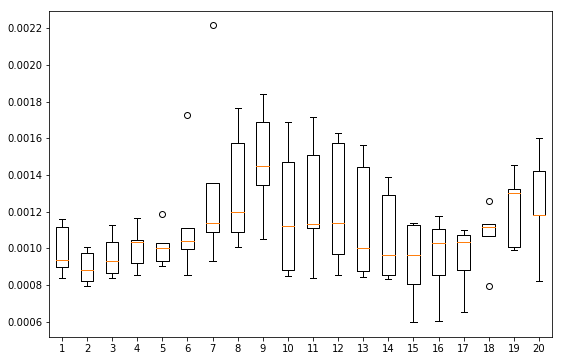

In [76]:
print(pval_FA)
fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)
bp = ax.boxplot(resu_FA)
plt.show()

In [7]:
hue = [0.0, 0.0]  # red only
saturation = [0.0, 1.0]  # white to red
lut_cmap = actor.colormap_lookup_table(hue_range=hue,saturation_range=saturation)

#streams, hdr = load_trk(FS_PATH+"slf_ii.left.trk")
streams, hdr = load_trk('/home/romain/Téléchargements/tracks/association/SLF_L.trk.gz')
fix_tracks = Streamlines(streams)

ren = window.ren()
data, affine = load_nifti("/home/global/fsl5011/data/standard/MNI152_T1_1mm_brain.nii.gz")      
ren.add(actor.line(fix_tracks,window.colors.white,linewidth=0.1))
fix_tracks_MNI = transform_streamlines(fix_tracks,np.linalg.inv(affine))
ren.add(actor.line(fix_tracks_MNI,window.colors.white,linewidth=0.1))
surface_opacity = 0.1
surface_color = [0.75, 0.75, 0.75]
v = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0],[0, 0, 0, 1]])
ren.add(actor.contour_from_roi(data,affine,surface_color, surface_opacity))
ren.add(actor.contour_from_roi(data,v,surface_color, surface_opacity))
window.show(ren) 

In [49]:
from sklearn.metrics import jaccard_similarity_score
data1, affine1 = load_nifti("/NAS/dumbo/protocoles/strokconnect/rs/results/conn_strokConnect15/results/secondlevel/ANALYSIS_01/t/rest/aIPS/results_ROIs.nii")    
data2, affine2 = load_nifti("/NAS/dumbo/protocoles/strokconnect/rs/results/conn_strokConnect15/results/secondlevel/ANALYSIS_01/p/rest/aIPS/results_ROIs.nii")
print(data1.shape)
print(type(data1))
print(jaccard_similarity_score(data2.flatten(),data1.flatten()))
data1, affine1 = load_nifti("/NAS/dumbo/protocoles/strokconnect/rs/results/conn_strokConnect15/results/secondlevel/ANALYSIS_01/t/rest/pIPS/results_ROIs.nii")    
data2, affine2 = load_nifti("/NAS/dumbo/protocoles/strokconnect/rs/results/conn_strokConnect15/results/secondlevel/ANALYSIS_01/p/rest/pIPS/results.ROIs.nii")
print(data1.shape)
print(type(data1))
print(jaccard_similarity_score(data2.flatten(),data1.flatten()))
data1, affine1 = load_nifti("/NAS/dumbo/protocoles/strokconnect/rs/results/conn_strokConnect15/results/secondlevel/ANALYSIS_01/t/rest/SPOC/results_ROIs.nii")    
data2, affine2 = load_nifti("/NAS/dumbo/protocoles/strokconnect/rs/results/conn_strokConnect15/results/secondlevel/ANALYSIS_01/p/rest/SPOC/results.ROIs.nii")
print(data1.shape)
print(type(data1))
print(jaccard_similarity_score(data2.flatten(),data1.flatten()))

(75, 94, 76)
<class 'numpy.core.memmap.memmap'>
0.968445315416
(75, 94, 76)
<class 'numpy.core.memmap.memmap'>
0.972166853303
(75, 94, 76)
<class 'numpy.core.memmap.memmap'>
0.98017170586


In [82]:
ren = window.ren()
for root, dirs, files in os.walk("/NAS/dumbo/protocoles/strokconnect/QA_DTI/DE_RIEMAECKER^HENRI_I_CERE_2015-09-08/dti/*.dpy"):    
    print(files)
    for file in files:
            dpw = dp.io.dpy.Dpy(file, 'r')
            tracks=dpw.read_tracks();
            print(str(len(tracks)))                 
            ren.add(actor.line(tracks,linewidth=1))
window.show(ren)    

In [24]:
#for root, dirs, files in os.walk("/NAS/tupac/protocoles/healthy_volunteers/FS53/T02S01/dti/*.tck"):    
dpw = dp.io.dpy.Dpy("/NAS/tupac/protocoles/healthy_volunteers/FS53/T02S01/dti/whole_brain.dpy", 'w')                
TCK_LOCATION="/NAS/tupac/protocoles/healthy_volunteers/FS53/T02S01/dti/"
for root, dirs, files in os.walk(TCK_LOCATION):    
    for file in files:
        if file.startswith('whole_brain_6_1500000_part000') & file.endswith('.tck'):
            bundle = nib.streamlines.load(root+file)
            dpw.write_tracks(bundle.streamlines)
dpw.close()

IOError: [Errno 2] No such file or directory: '/NAS/tupac/protocoles/healthy_volunteers/FS53/T02S01/dti/MNIspacewhole_brain_6_1500000_part000118.tck'

In [ ]:
ren = window.ren()
dpw = dp.io.dpy.Dpy("/NAS/tupac/protocoles/healthy_volunteers/FS53/T02S01/dti/whole_brain.dpy", 'r')
#tracks=dpw.read_tracks();
tracks = dpw.read_tracksi(range(1,20000))
#print(str(len(tracks)))                 
ren.add(actor.line(tracks,linewidth=0.1))
window.show(ren)

In [12]:
ren = window.ren()
#ren.background((0.5, 0.5, 0.5))
#for cpt in np.arange(10,5000,500):
#dpw = dp.io.dpy.Dpy("/NAS/tupac/protocoles/healthy_volunteers/FS53/T02S01/dti/whole_brain.dpy", 'r')
cpt=50000
#tracks = dpw.read_tracksi(range(1,cpt))
ren.add(actor.line(tracks,window.colors.blue,linewidth=0.2,opacity=0.2))
window.show(ren,size=(1800,1800),reset_camera=True)
window.record(ren, out_path='slices'+str(cpt)+'_blue.png', size=(1800,1800),reset_camera=True)

NameError: name 'tracks' is not defined

In [32]:
    print('slices.png'+str(cpt))

slices.png70000


In [13]:
renderer = window.Renderer()
renderer.background((0.5, 0.5, 0.5))
fa_actor = actor.slicer(tenfit.color_fa, affine)
renderer.add(fa_actor)
window.show(renderer, size=(600,600), reset_camera=True)

window.record(renderer, out_path='slices.png', size=(600,600),reset_camera=True)

NameError: name 'tenfit' is not defined

In [14]:
ren = window.ren()
STR_PATH="/NAS/dumbo/protocoles/strokconnect/FS53/DE_RIEMAECKER^HENRI_I_CERE_2015-09-08/dti/"
ren.SetBackground(1, 1, 1)
dpw = dp.io.dpy.Dpy(STR_PATH+"slf_1.left.dpy", 'r')
tracks=dpw.read_tracks();
print(str(len(tracks)))                 
ren.add(actor.line(tracks,linewidth=1))
window.show(ren)

IOError: Unable to open file (Unable to open file: name = '/nas/dumbo/protocoles/strokconnect/fs53/de_riemaecker^henri_i_cere_2015-09-08/dti/slf_1.left.dpy', errno = 2, error message = 'no such file or directory', flags = 0, o_flags = 0)